In [1]:
import pandas as pd
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
%matplotlib inline

In [2]:
df_plays = pd.read_pickle("data/plays.csv.x.pickle").set_index(['gameId', 'playId'])
df_games = pd.read_pickle("data/games.csv.x.pickle").set_index(['gameId'])

In [3]:
df_players = pd.read_pickle("data/players.csv.x.pickle").set_index('nflId')
df_players.columns

Index(['height', 'weight', 'birthDate', 'collegeName', 'position',
       'displayName', 'shortName'],
      dtype='object')

In [4]:
df_pg = df_plays.join(df_games)


In [5]:
df_pg.columns

Index(['playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'playType', 'yardlineSide', 'yardlineNumber', 'offenseFormation',
       'personnelO', 'defendersInTheBox', 'numberOfPassRushers', 'personnelD',
       'typeDropback', 'preSnapVisitorScore', 'preSnapHomeScore', 'gameClock',
       'absoluteYardlineNumber', 'penaltyCodes', 'penaltyJerseyNumbers',
       'passResult', 'offensePlayResult', 'playResult', 'epa', 'isDefensivePI',
       'oid', 'did', 'gameDate', 'gameTimeEastern', 'homeTeamAbbr',
       'visitorTeamAbbr', 'week'],
      dtype='object')

In [6]:
def fNorm(d):
    if d['iplayDirection'] == 1:
        return d['x'] - 10 - (100 - d['los'] )
    else:
        return -1*(d['x'] - d['los'] - 10)

evntqry='event in ["ball_snap","pass_forward","pass_arrived","pass_outcome_caught","pass_outcome_incomplete","pass_outcome_interception","pass_outcome_touchdown"]'
    
df = pd.DataFrame()
for i in range(1,18):
    file = "data/week%d.csv.y.pickle" % i
    df1 = pd.read_pickle(file).set_index(['gameId','playId','frameId','nflId']).query(evntqry)
    df = pd.concat([df,df1]) 

df['x0'] = df[['iplayDirection','los','x']].apply(fNorm, axis=1)

df = df.join(df_players[['height','weight']])

In [7]:
df['nx'] = df[['x0']] - df.loc[:,:,:,-2][['x0']]
df['ny'] = df[['y']] - df.loc[:,:,:,-2][['y']]
df['nfx'] = df[['x0']] - df.loc[:,:,:,-1][['x0']]
df['nfy'] = df[['y']] - df.loc[:,:,:,-1][['y']]

In [8]:
# Box x and y into a grid
gridsize = 2
gridcenter = 1
df['gx'] = df['nx'].fillna(0).apply(lambda x : x - x%gridsize + gridcenter)
df['gy'] = df['ny'].fillna(0).apply(lambda y : y - y%gridsize + gridcenter)

In [9]:
df.columns

Index(['time', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'event', 'displayName',
       'jerseyNumber', 'position', 'team', 'playDirection', 'route', 'upos',
       'iteam', 'iplayDirection', 'one', 'bdefense', 'los', 'yardsToGo',
       'absoluteYardlineNumber', 'down', 'passResult', 'oid', 'did', 'defTeam',
       'offenseFormation', 'defendersInTheBox', 'numberOfPassRushers',
       'typeDropback', 'fx', 'fy', 'd2fb', 'ox', 'oy', 'd2oid', 'x0', 'height',
       'weight', 'nx', 'ny', 'nfx', 'nfy', 'gx', 'gy'],
      dtype='object')

In [64]:
n = df.query('bdefense==-1 and nflId>0 and event=="ball_snap"')['one'].sum()
df['C'] = 100./n

In [112]:
def fplot(evt, pr, pos='all', qry=''):
    fig = plt.figure(figsize=(18,4))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)

    X,Y=('ny','nx')
    
    df['C'] = 2
    
    def fplot1(ax, r, pr, evt, pos='all', qry=''): 
        and1 = ' and position=="%s"' % pos if pos != 'all' else ''
        qry2 = ' and ' + qry if len(qry) else ''
        qry1 = 'and event=="%s" and passResult=="%s" and d2oid<%d %s' % (evt,pr,r,qry2) 
        #df.query('bdefense==1  and nflId>0 %s' % (qry1)).plot(x=X, y=Y, style='.g', ax=ax)
        dfd = df.query('bdefense==-1 and nflId>0 %s %s' % (qry1,and1))
        dfd.plot.hexbin(x=X, y=Y, gridsize=20, ax=ax, cmap='Reds', bins=[0,2,4,8,16,32,64,128,256,512])
        df.query('nflId==-2 and event=="%s" and passResult=="%s"' % (evt,pr)).plot(x=X, y=Y, style = 'Xb', ax=ax)
        ax.get_legend().remove()
        ax.set_title("%s - %s - defenders(%s) within %d yards" % (evt.split('_')[-1],pr,pos,r))
    
    fplot1(ax1, 2, pr, evt, pos, qry)
    fplot1(ax2, 5, pr, evt, pos, qry)
    fplot1(ax3, 10,pr, evt, pos, qry)

    plt.show()


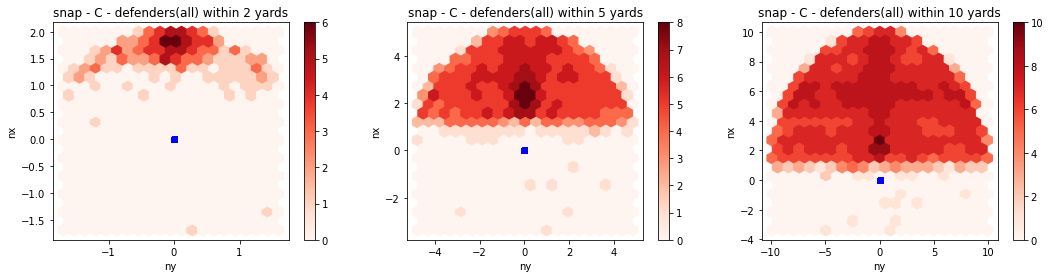

In [113]:
fplot("ball_snap", "C")

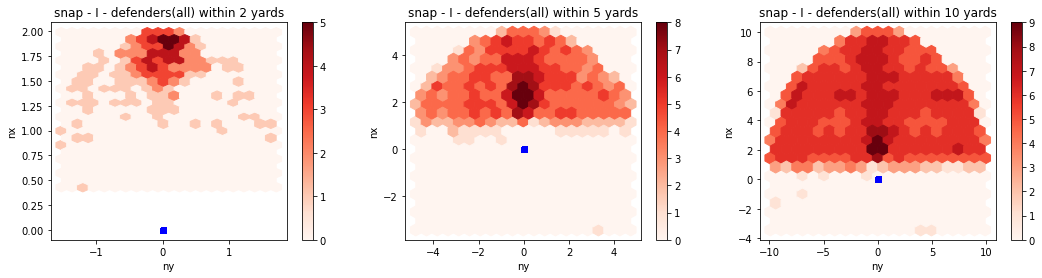

In [114]:
fplot("ball_snap", "I")

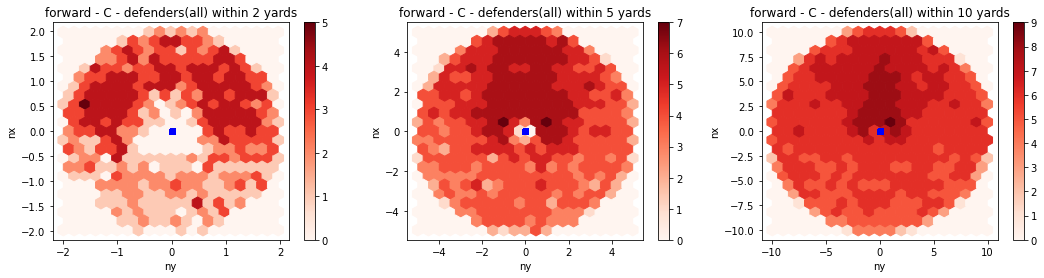

In [115]:
fplot("pass_forward", "C")

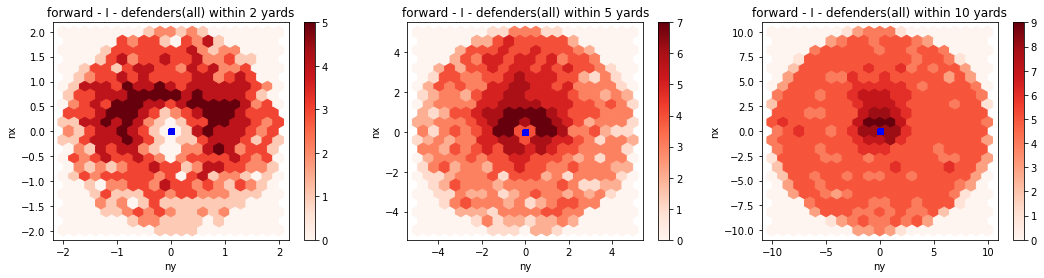

In [116]:
fplot("pass_forward", "I")

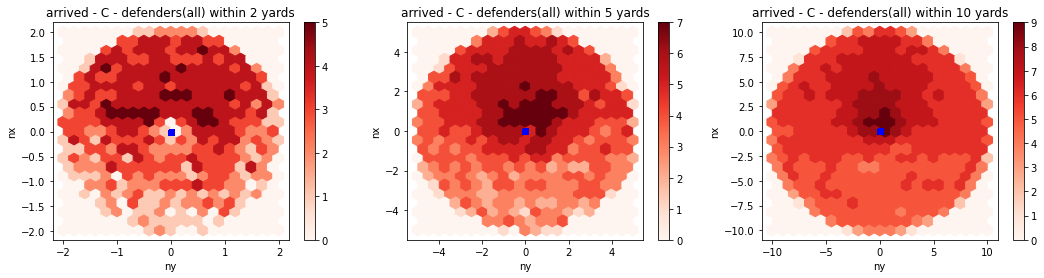

In [117]:
fplot("pass_arrived", "C")

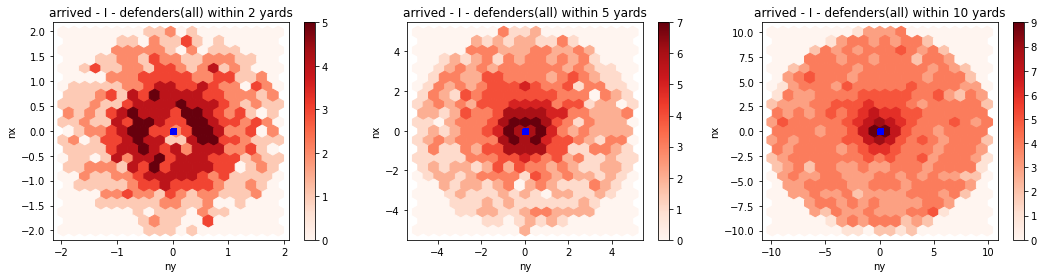

In [118]:
fplot("pass_arrived", "I")

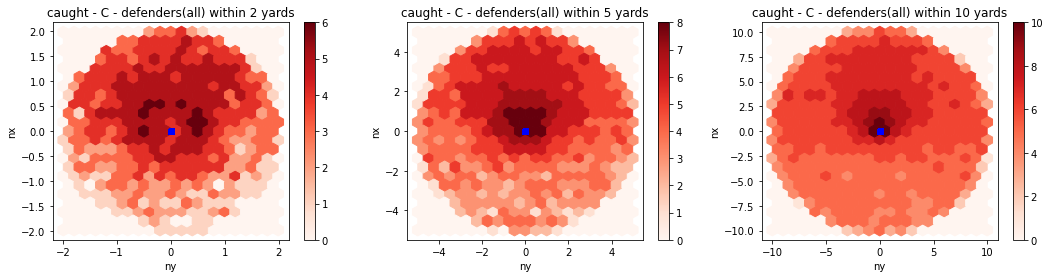

In [119]:
fplot("pass_outcome_caught", "C")

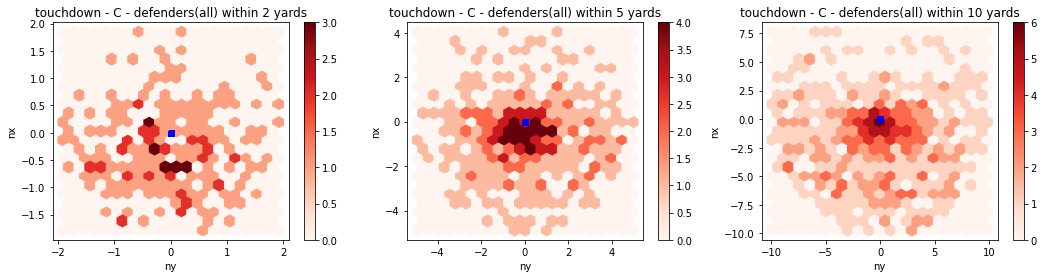

In [120]:
fplot("pass_outcome_touchdown", "C")

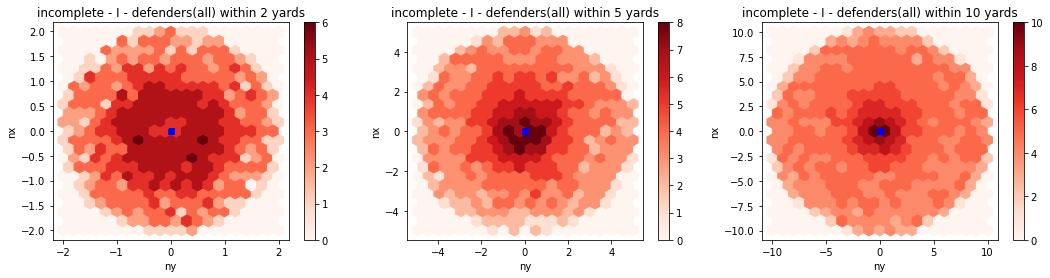

In [121]:
fplot("pass_outcome_incomplete", "I")

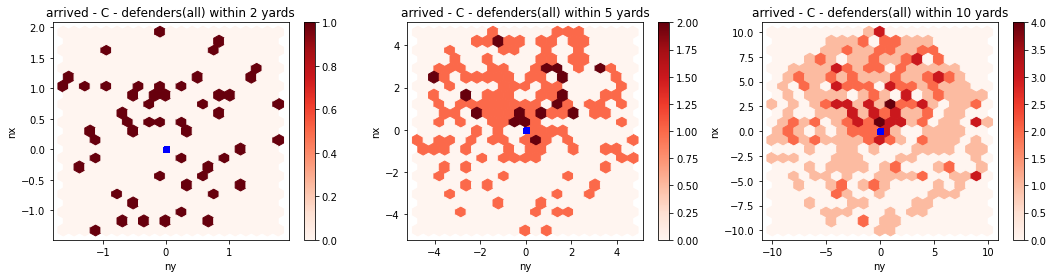

In [172]:
fplot("pass_arrived", "C", qry='defTeam=="OAK"')

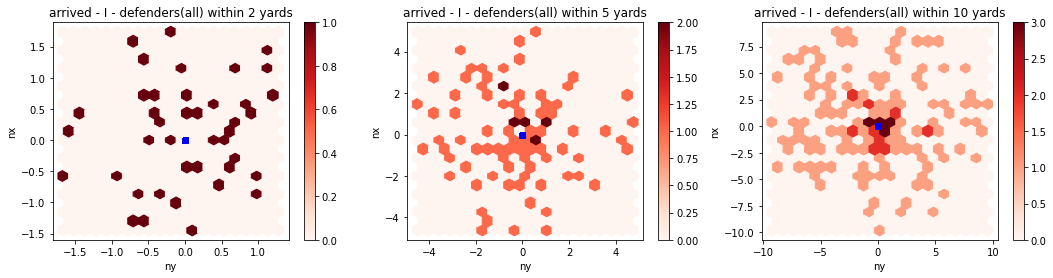

In [173]:
fplot("pass_arrived", "I", qry='defTeam=="OAK"')

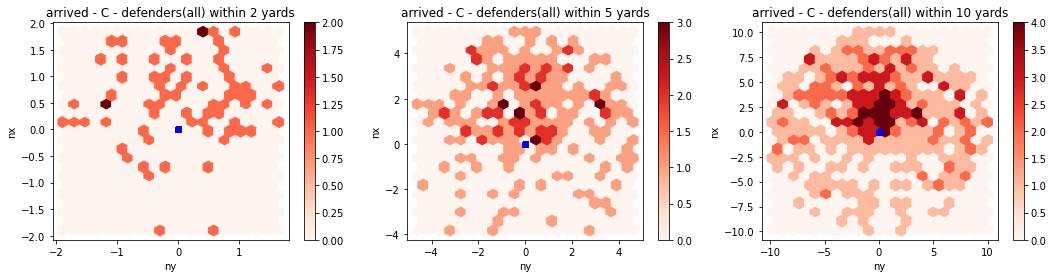

In [174]:
fplot("pass_arrived", "C", qry='defTeam=="CHI"')

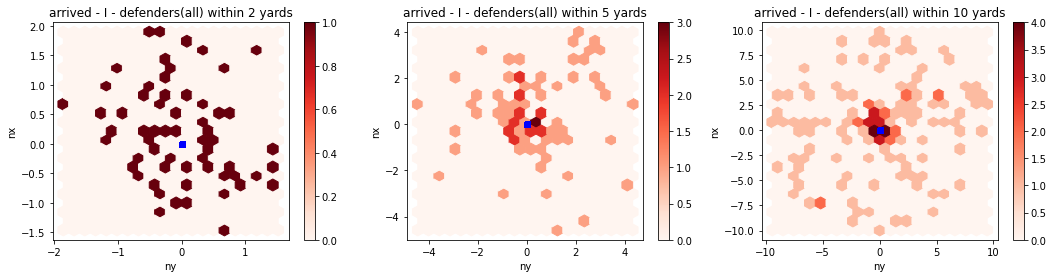

In [175]:
fplot("pass_arrived", "I", qry='defTeam=="CHI"')

In [140]:
gid = 2018100704 #
pid = 1686 #
print(df_plays.loc[gid,pid][['playDescription']])

playDescription    (5:13) (Shotgun) A.Rodgers pass deep left to D...
Name: (2018100704, 1686), dtype: object


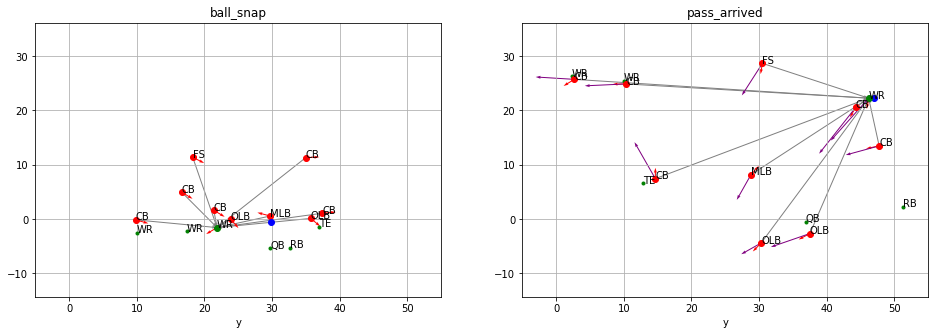

In [142]:
df['so'] = df.o.apply(lambda t : 2*math.sin(t*math.pi/180))
df['co'] = df.o.apply(lambda t : 2*math.cos(t*math.pi/180))
df['sdir'] = df[['dir','s']].apply(lambda d : d['s']*math.sin(d['dir']*math.pi/180), axis=1)
df['cdir'] = df[['dir','s']].apply(lambda d : d['s']*math.cos(d['dir']*math.pi/180), axis=1)

X,Y=('y','x0')

axx = []

xmin = df.loc[gid,pid].x0.min()-5
xmax = df.loc[gid,pid].x0.max()+5
r = 60/(xmax-xmin)
figsize = (16, 2*3/r)

fig = plt.figure(figsize=figsize)
axx = [fig.add_subplot(n) for n in [121,122]]

#evts = list(df.event.loc[gid,pid].unique())
evts = ['ball_snap','pass_arrived']
for i in range(len(evts)):
    axx[i].axis([-5,55,xmin,xmax])
    evt = evts[i]

    df.loc[gid,pid].query('bdefense==1 and event=="%s"' % evt).plot(x=X, y=Y, style='.g',  ax=axx[i])
    df.loc[gid,pid].query('bdefense==-1 and event=="%s"' % evt).plot(x=X, y=Y, style='or', ax=axx[i])
    df.loc[gid,pid].query('nflId == -1 and event=="%s"' % evt).plot(x=X, y=Y, style = 'ob', ax=axx[i])
    df.loc[gid,pid].query('nflId == -2 and event=="%s"' % evt).plot(x=X, y=Y, style = 'og', ax=axx[i])

    qry1 = '(bdefense==-1 or nflId==-2) and event=="%s"' % evt

    xy0 = df.loc[gid,pid].query(qry1)[['x0', 'y']].values
    dxy = df.loc[gid,pid].query(qry1)[['ox','oy']].values
    pdir = df.loc[gid,pid].iplayDirection.values[0]

    axx[i].quiver(xy0[:,1], xy0[:,0], -dxy[:,1], -pdir*dxy[:,0], color=["grey"], units='dots', angles='xy', scale_units='xy', scale=1, width=1)

    ouv = df.loc[gid,pid].query(qry1)[['co','so']].values
    axx[i].quiver(xy0[:,1], xy0[:,0], -ouv[:,1], -pdir*ouv[:,0], color=["red"], units='dots', angles='xy', scale_units='xy', scale=1, width=1 )

    diruv = df.loc[gid,pid].query(qry1)[['cdir','sdir']].values
    axx[i].quiver(xy0[:,1], xy0[:,0], -diruv[:,1], -pdir*diruv[:,0], color=["purple"], units='dots', angles='xy', scale_units='xy', scale=1, width=1)


    for d in df.loc[gid,pid].query('event=="%s"' % evt)[[Y,X,'position']].values[:-1]:
        axx[i].annotate(d[2],(d[1],d[0]))
    
    axx[i].set_title(evt)
    axx[i].get_legend().remove()
    axx[i].grid(which='both')

plt.show()           

In [152]:
df_plays_week = pd.read_pickle("data/week%d.csv.y.pickle" % 5).set_index(['gameId','playId','frameId','nflId'])
df_plays_week['x0'] = df_plays_week[['iplayDirection','los','x']].apply(fNorm, axis=1)

gid = 2018100704 #
pid = 1686 #

df_play = df_plays_week.loc[gid,pid]


(5:13) (Shotgun) A.Rodgers pass deep left to D.Adams pushed ob at DET 9 for 30 yards (D.Slay).
2543495 2543495


In [157]:
pdesc,oid,did = tuple(df_plays.loc[gid,pid][['playDescription','oid','did']])
did = 2540288
print(pdesc)
print(oid,did)

df_players.query('shortName=="D.Slay"')

(5:13) (Shotgun) A.Rodgers pass deep left to D.Adams pushed ob at DET 9 for 30 yards (D.Slay).
2543495 2540288


,height,weight,birthDate,collegeName,position,displayName,shortName
nflId,,,,,,,
2540288,72,190,1991-01-01,Mississippi State,CB,Darius Slay,D.Slay


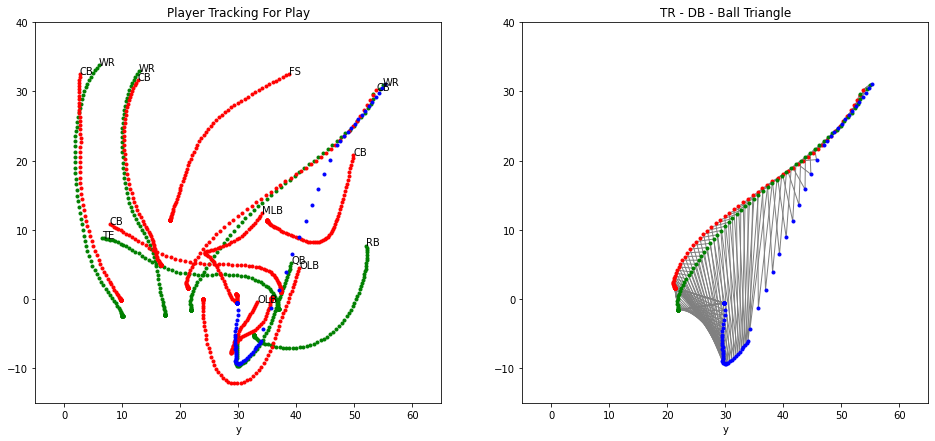

In [171]:
fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.axis([-5,65,-15,40])
ax1.set_title("Player Tracking For Play")
ax2.axis([-5,65,-15,40])
ax2.set_title("TR - DB - Ball Triangle")

X,Y=('y','x0')

df_play.query('bdefense==1 and nflId>0').plot(x=X, y=Y, style='.g', ax=ax1)
df_play.query('nflId == -2').plot(x=X, y=Y, style = '.g', ax=ax1)
df_play.query('bdefense==-1').plot(x=X, y=Y, style='.r', ax=ax1)
df_play.query('nflId == -1').plot(x=X, y=Y, style = '.b', ax=ax1)

mxfid, _ = df_play.iloc[-1:].index[0]
df_last = df_play.loc[mxfid]
for d in df_last[[Y,X,'position']].values[:-1]:
    ax1.annotate(d[2],(d[1],d[0]))

ax1.get_legend().remove()

df1 = df_plays_week.loc[gid,pid,:,did].reset_index()
df2 = df_plays_week.loc[gid,pid,:,-2].reset_index()
df3 = df_plays_week.loc[gid,pid,:,-1].reset_index()

dfp = pd.merge_ordered(df1[['frameId',Y,X]],df2[['frameId',Y,X]])
dfp = pd.merge_ordered(dfp,df3[['frameId',Y,X]])

df1.plot(y=Y, x=X, style='.r', ax=ax2)
df2.plot(y=Y, x=X, style='.g', ax=ax2)
df3.plot(y=Y, x=X, style='.b', ax=ax2)

for i in range(0,len(dfp),3):
    t1 = plt.Polygon(dfp[[X,Y]].values[i:i+3,:], fill=False, color='grey')
    plt.gca().add_patch(t1)

ax2.get_legend().remove()

plt.show()           

CB WR


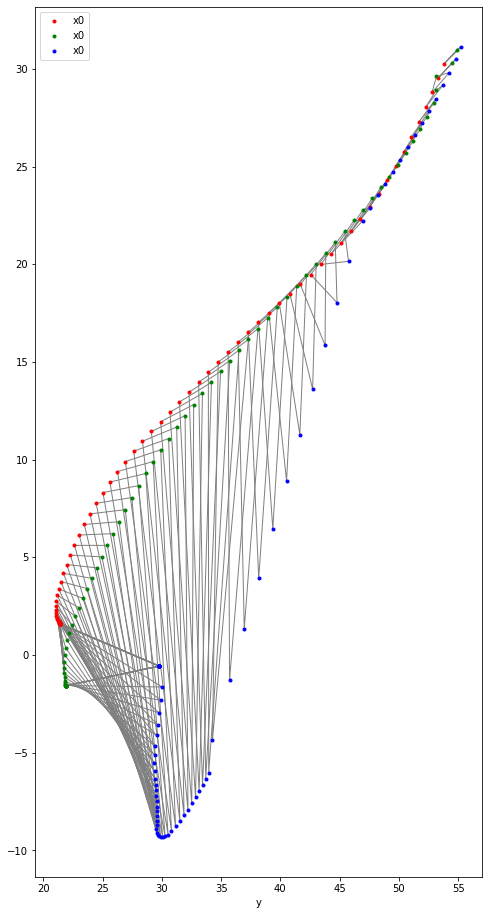

In [159]:
df1 = df_plays_week.loc[gid,pid,:,did].reset_index()
df2 = df_plays_week.loc[gid,pid,:,-2].reset_index()
df3 = df_plays_week.loc[gid,pid,:,-1].reset_index()

X,Y=('y','x0')

print(df1.position.values[0], df2.position.values[0])

dfp = pd.merge_ordered(df1[['frameId',Y,X]],df2[['frameId',Y,X]])
dfp = pd.merge_ordered(dfp,df3[['frameId',Y,X]])

fig, ax1 = plt.subplots()
df1.plot(y=Y, x=X, style='.r', figsize=(8,16), ax=ax1)
df2.plot(y=Y, x=X, style='.g', ax=ax1)
df3.plot(y=Y, x=X, style='.b', ax=ax1)

for i in range(0,len(dfp),3):
    t1 = plt.Polygon(dfp[[X,Y]].values[i:i+3,:], fill=False, color='grey')
    plt.gca().add_patch(t1)
    
plt.show()

In [24]:
df1 = df.query('event=="pass_arrived"').reset_index().set_index(['gameId','playId','frameId']).query('bdefense==-1')\
    [['upos','nx','ny','d2oid','o','dir','height','weight']]

df2 = df.query('event=="pass_arrived"').reset_index().set_index(['gameId','playId','frameId']).query('nflId==-2')\
  [['yardsToGo','down','route','defTeam','offenseFormation','typeDropback',\
    'defendersInTheBox', 'numberOfPassRushers','absoluteYardlineNumber','passResult']]

In [25]:
df3 = df1.pivot(columns='upos').fillna(0).join(df2)

/home/ec2-user/.conda/envs/python/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [26]:
df3['route'] = df3.route.astype('category').cat.codes
df3['passResult'] = df3.passResult.astype('category').cat.codes
df3['defTeam'] = df3.defTeam.astype('category').cat.codes
df3['offenseFormation'] =df3.offenseFormation.astype('category').cat.codes
df3['typeDropback'] =df3.typeDropback.astype('category').cat.codes

In [27]:
df3.to_pickle("data/EventPassArrives.pickle")